In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [3]:
file_path = r"F:\neuron project with Jesus"

df0 = pd.read_csv(f"{file_path}/filter_renamed_raw_matrix.csv", index_col = 0)

In [5]:
df = df0.copy()

# 统一所有名字为字符串（解决你刚才那个 sklearn 报错）
df.index = df.index.astype(str)
df.columns = df.columns.astype(str)

# 只保留数值
df = df.apply(pd.to_numeric, errors="coerce")

print("Matrix:", df.shape)  # proteins x samples

Matrix: (8753, 95)


In [6]:
# import scanpy as sc

In [7]:
# ---- Set global font once ----
plt.rcParams["font.family"] = "Arial"

In [6]:
import re

def parse_sample_name(s: str):
    s = str(s)
    parts = s.split("_")

    # ---------- 1. replicate ----------
    rep = None
    if re.fullmatch(r"\d+", parts[-1]):
        rep = parts[-1]
        core = "_".join(parts[:-1])   # 去掉 replicate
    else:
        m = re.search(r"(.*?)(\d+)$", s)
        if m:
            core = m.group(1).rstrip("_- ")
            rep = m.group(2)
        else:
            core = s

    # ---------- 2. time line（ style） ----------

    m_time = re.search(r"(\d+)\s*d", core, re.IGNORECASE)
    Time_points = f"{m_time.group(1)}d" if m_time else "NA"

    # ---------- 3. Cell_Drug（用于颜色） ----------
    # 去掉 time，只保留 drug / condition
    if m_time:
        Cell_Drug = core.replace(m_time.group(0), "").rstrip("_- ")
    else:
        Cell_Drug = core

    return Time_points, Cell_Drug, rep


In [7]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# samples x features
X = df.T.copy()
X = X.apply(pd.to_numeric, errors="coerce")
X.columns = X.columns.astype(str)

X_imp = KNNImputer(n_neighbors=5, weights="distance").fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imp)

pca = PCA(n_components=2, random_state=42)
PC = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(PC, columns=["PC1","PC2"], index=X.index)

meta = pd.DataFrame([parse_sample_name(c) for c in X.index],
                    columns=["Time_points","Cell_Drug","rep"],
                    index=X.index)

pca_df = pca_df.join(meta)


In [8]:
pca_df 

,PC1,PC2,Time_points,Cell_Drug,rep
CL2_VEH_3d_1,83.300767,-32.796605,3d,CL2_VEH,1
CL2_VEH_3d_2,105.130358,-41.131636,3d,CL2_VEH,2
CL2_VEH_3d_3,123.596163,-46.332205,3d,CL2_VEH,3
CL2_VEH_3d_4,109.407278,-43.826783,3d,CL2_VEH,4
CL2_VEH_3d_5,139.615706,-41.720157,3d,CL2_VEH,5
...,...,...,...,...,...
CL5_DAPT_16d_2,7.397545,62.976922,16d,CL5_DAPT,2
CL5_DAPT_16d_3,-3.134162,64.281631,16d,CL5_DAPT,3
CL5_DAPT_16d_4,5.110598,16.309132,16d,CL5_DAPT,4
CL5_DAPT_16d_5,8.868981,63.956974,16d,CL5_DAPT,5


In [9]:
marker_map = {
    "3d": "o",   # 圆
    "4d": "s",   # 方
    "8d": "^",   # 三角
    "16d": "*",  # 菱形
}

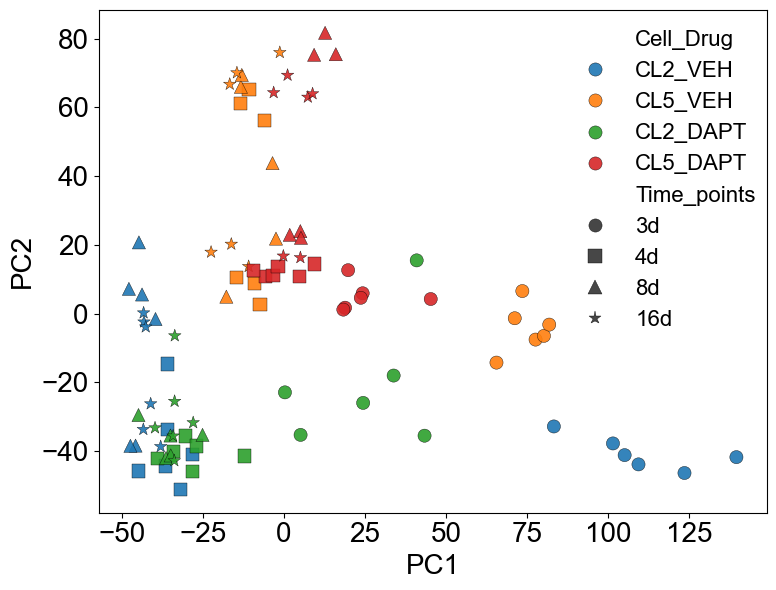

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Cell_Drug",
    style="Time_points",      # marker = cell line
    # palette=colors,      # 👈 手动 viridis 离散色
    markers=marker_map, 
    s=90,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.3
)

plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# plt.title("PCA", fontsize=16)
plt.legend(bbox_to_anchor=(0.68,1), loc="upper left", frameon=False,fontsize=16)
plt.tight_layout()
plt.savefig(r"C:\projectx work with Jesus\New results (doxycycline time course)\figures\PCA_16treatments.svg", 
            dpi=600, bbox_inches="tight")
plt.show()


In [8]:
trea = df.columns.str.replace(r"_\d+$", "", regex=True)
df2 = df.copy()
df2.columns = trea
df2

,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_3d,CL5_VEH_3d,CL5_VEH_3d,CL5_VEH_3d,CL5_VEH_3d,...,CL2_DAPT_16d,CL2_DAPT_16d,CL2_DAPT_16d,CL2_DAPT_16d,CL5_DAPT_16d,CL5_DAPT_16d,CL5_DAPT_16d,CL5_DAPT_16d,CL5_DAPT_16d,CL5_DAPT_16d
Genes,,,,,,,,,,,,,,,,,,,,,
NUDT4B,537378.0,715529.0,891815.00,1109930.0,671624.0,1038120.0,366861.0,505967.0,407748.00,457274.0,...,429851.00,541818.0,514498.00,515546.0,538364.0,575636.0,607012.0,586532.0,628174.0,538023.0
PIGBOS1,31689.1,168546.0,42261.10,42246.3,NaN,NaN,159359.0,38719.9,NaN,164553.0,...,55695.30,57692.7,30121.80,NaN,30409.6,74205.8,40609.9,NaN,44623.6,66148.4
TMEM275,67777.3,31910.6,99747.60,46045.0,53093.8,39986.9,117568.0,88769.4,130019.00,149649.0,...,27415.80,NaN,76116.90,NaN,69326.5,69009.2,58308.2,NaN,54567.2,57538.0
CENPVL1,17992.2,16976.2,7475.95,25831.0,17926.5,17589.5,55468.7,41741.8,54137.70,66724.9,...,7033.51,16311.4,9453.53,34999.3,45253.9,51757.7,25132.8,33391.4,29245.4,22509.0
NBDY,954028.0,681522.0,731666.00,585953.0,671031.0,605351.0,755292.0,638894.0,632823.00,701138.0,...,358583.00,586829.0,317068.00,554519.0,453530.0,603996.0,325114.0,367215.0,328900.0,557972.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MYO16,89141.0,87469.4,74539.50,84696.2,105419.0,58427.7,104347.0,70757.5,97873.00,81302.3,...,128957.00,109979.0,132658.00,99003.3,123061.0,146071.0,94985.9,94516.5,121374.0,134758.0
MORC2,1892940.0,1454230.0,1821140.00,1642340.0,1817900.0,1676320.0,2011200.0,1748410.0,1898360.00,1649060.0,...,2555800.00,2534990.0,2513730.00,2623680.0,1894660.0,1848480.0,1765020.0,1963490.0,1903060.0,1972260.0
IVNS1ABP,526229.0,524431.0,568194.00,605885.0,799871.0,705138.0,551678.0,584367.0,425735.00,515127.0,...,295407.00,350116.0,427796.00,410643.0,463163.0,530948.0,467519.0,475551.0,522119.0,414017.0


In [9]:
df_sub = df2.loc[:, df2.columns.str.contains("CL2_VEH")]
df_sub

,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_3d,CL2_VEH_4d,CL2_VEH_4d,CL2_VEH_4d,CL2_VEH_4d,...,CL2_VEH_8d,CL2_VEH_8d,CL2_VEH_8d,CL2_VEH_8d,CL2_VEH_16d,CL2_VEH_16d,CL2_VEH_16d,CL2_VEH_16d,CL2_VEH_16d,CL2_VEH_16d
Genes,,,,,,,,,,,,,,,,,,,,,
NUDT4B,537378.0,715529.0,891815.00,1109930.0,671624.0,1038120.0,483422.0,556895.0,431548.0,461149.0,...,543800.0,503318.0,561523.0,531052.0,548419.0,496578.0,504883.0,415922.00,527556.0,613055.0
PIGBOS1,31689.1,168546.0,42261.10,42246.3,NaN,NaN,42677.2,120160.0,30173.8,NaN,...,39275.2,NaN,30634.7,39577.5,41273.2,NaN,37954.0,NaN,NaN,36010.2
TMEM275,67777.3,31910.6,99747.60,46045.0,53093.8,39986.9,45845.2,49209.4,24329.7,24659.0,...,30969.7,33594.4,34314.8,40797.5,27866.7,17390.9,15863.6,23542.70,NaN,NaN
CENPVL1,17992.2,16976.2,7475.95,25831.0,17926.5,17589.5,7781.9,10680.4,12929.6,10603.4,...,11658.8,14787.1,13510.5,19174.6,13255.3,11511.0,11093.9,9047.08,10491.5,17269.2
NBDY,954028.0,681522.0,731666.00,585953.0,671031.0,605351.0,194710.0,614725.0,513811.0,552460.0,...,221367.0,530398.0,331379.0,318263.0,453869.0,231620.0,285627.0,706906.00,394698.0,329334.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MYO16,89141.0,87469.4,74539.50,84696.2,105419.0,58427.7,132914.0,124058.0,109843.0,104374.0,...,100525.0,128233.0,147611.0,92375.8,147251.0,103537.0,97266.4,105058.00,129091.0,68795.7
MORC2,1892940.0,1454230.0,1821140.00,1642340.0,1817900.0,1676320.0,2281560.0,2038800.0,2247210.0,2516930.0,...,2624910.0,2511610.0,2900290.0,2851010.0,2317380.0,2641920.0,2696990.0,2448830.00,2781120.0,2891990.0
IVNS1ABP,526229.0,524431.0,568194.00,605885.0,799871.0,705138.0,279761.0,247917.0,325178.0,239912.0,...,316285.0,318004.0,384727.0,324931.0,328309.0,349510.0,390791.0,258510.00,357881.0,430137.0


In [10]:
df_mean = df2.groupby(level=0, axis=1).mean()
df_mean

,CL2_DAPT_16d,CL2_DAPT_3d,CL2_DAPT_4d,CL2_DAPT_8d,CL2_VEH_16d,CL2_VEH_3d,CL2_VEH_4d,CL2_VEH_8d,CL5_DAPT_16d,CL5_DAPT_3d,CL5_DAPT_4d,CL5_DAPT_8d,CL5_VEH_16d,CL5_VEH_3d,CL5_VEH_4d,CL5_VEH_8d
Genes,,,,,,,,,,,,,,,,
NUDT4B,5.179737e+05,4.490085e+05,3.967870e+05,4.725535e+05,5.177355e+05,8.273993e+05,4.688145e+05,5.287547e+05,5.789568e+05,6.079555e+05,5.380950e+05,6.078428e+05,5.664515e+05,4.139207e+05,5.604472e+05,6.136464e+05
PIGBOS1,5.479885e+04,4.481450e+04,7.731945e+04,4.430370e+04,3.841247e+04,7.118562e+04,5.689055e+04,3.649580e+04,5.119946e+04,4.858903e+04,3.788963e+04,3.978347e+04,2.572970e+04,1.111329e+05,3.436320e+04,3.210127e+04
TMEM275,4.746277e+04,3.218292e+04,7.580547e+04,3.929692e+04,2.116597e+04,5.642687e+04,4.441465e+04,3.419412e+04,6.174982e+04,1.340698e+05,1.350619e+05,8.114072e+04,4.759676e+04,1.265084e+05,9.291108e+04,7.317170e+04
CENPVL1,1.464159e+04,1.836138e+04,1.108003e+04,1.469124e+04,1.211133e+04,1.729856e+04,1.174197e+04,1.396435e+04,3.454837e+04,3.705632e+04,2.409688e+04,2.453133e+04,2.912832e+04,4.660178e+04,2.293522e+04,3.355278e+04
NBDY,4.548480e+05,4.111993e+05,5.525708e+05,3.271800e+05,4.003423e+05,7.049252e+05,4.696895e+05,2.982475e+05,4.394545e+05,2.921297e+05,3.091340e+05,2.133388e+05,2.707232e+05,6.423182e+05,3.392543e+05,3.015012e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MYO16,1.162009e+05,1.404788e+05,1.332558e+05,1.256843e+05,1.084998e+05,8.328213e+04,1.189821e+05,1.228905e+05,1.191277e+05,1.034841e+05,1.184377e+05,1.008837e+05,1.071084e+05,9.442633e+04,1.185695e+05,1.269345e+05
MORC2,2.546558e+06,1.950293e+06,2.246458e+06,2.571257e+06,2.629705e+06,1.717478e+06,2.325160e+06,2.637828e+06,1.891162e+06,2.083343e+06,1.929087e+06,1.962393e+06,2.004057e+06,1.857258e+06,1.872158e+06,1.886904e+06
IVNS1ABP,3.702628e+05,3.654877e+05,2.700277e+05,3.383153e+05,3.525230e+05,6.216247e+05,2.742952e+05,3.286427e+05,4.788862e+05,4.495312e+05,4.019015e+05,5.257687e+05,4.152678e+05,5.128070e+05,3.717312e+05,4.099540e+05


In [11]:
dfs = df_mean.copy()

df_log = dfs.where(dfs > 0)
df_log = df_log.apply(np.log2)

df_z = df_log.sub(df_log.mean(axis=1), axis=0)\
             .div(df_log.std(axis=1), axis=0)\
             .fillna(0)


In [13]:
import seaborn as sns

In [17]:
ordered = [ 'CL2_DAPT_3d', 'CL2_DAPT_4d', 'CL2_DAPT_8d','CL2_DAPT_16d',
            'CL2_VEH_3d', 'CL2_VEH_4d', 'CL2_VEH_8d',  'CL2_VEH_16d',
            'CL5_DAPT_3d', 'CL5_DAPT_4d', 'CL5_DAPT_8d','CL5_DAPT_16d', 
            'CL5_VEH_3d', 'CL5_VEH_4d', 'CL5_VEH_8d','CL5_VEH_16d']

dfz_2 = df_z[ordered]

dfz_2

,CL2_DAPT_3d,CL2_DAPT_4d,CL2_DAPT_8d,CL2_DAPT_16d,CL2_VEH_3d,CL2_VEH_4d,CL2_VEH_8d,CL2_VEH_16d,CL5_DAPT_3d,CL5_DAPT_4d,CL5_DAPT_8d,CL5_DAPT_16d,CL5_VEH_3d,CL5_VEH_4d,CL5_VEH_8d,CL5_VEH_16d
Genes,,,,,,,,,,,,,,,,
NUDT4B,-0.969188,-1.664668,-0.681702,-0.165482,2.469031,-0.726386,-0.049608,-0.168069,0.735505,0.048888,0.734463,0.460593,-1.426876,0.277822,0.787914,0.337764
PIGBOS1,-0.129125,1.357025,-0.160361,0.418937,1.131807,0.521008,-0.688623,-0.549154,0.091220,-0.586496,-0.453596,0.233813,2.345535,-0.852686,-1.038221,-1.641084
TMEM275,-1.158415,0.421677,-0.790085,-0.441879,-0.122812,-0.564298,-1.046616,-1.931260,1.473290,1.486887,0.547118,0.043445,1.366224,0.796945,0.356459,-0.436680
CENPVL1,-0.269406,-1.378592,-0.759100,-0.766533,-0.400343,-1.251172,-0.870530,-1.183159,1.272565,0.327525,0.366763,1.118676,1.775877,0.219025,1.054466,0.743939
NBDY,0.228705,1.130100,-0.468511,0.536442,1.872895,0.634385,-0.750936,0.147082,-0.814157,-0.641576,-1.772937,0.431420,1.589187,-0.357967,-0.717838,-1.046293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MYO16,1.569062,1.173061,0.734215,0.145658,-2.353158,0.323098,0.565568,-0.368767,-0.723840,0.288696,-0.914770,0.332277,-1.411011,0.297040,0.808465,-0.465596
MORC2,-0.555401,0.434644,1.380324,1.312731,-1.445637,0.675784,1.559328,1.537729,-0.093246,-0.631965,-0.512087,-0.771012,-0.897695,-0.841737,-0.786796,-0.364965
IVNS1ABP,-0.348645,-1.679688,-0.688341,-0.291568,1.986682,-1.610740,-0.815890,-0.507454,0.561438,0.068969,1.250273,0.839590,1.140514,-0.274165,0.156199,0.212828


C:\Users\jymbc\Anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


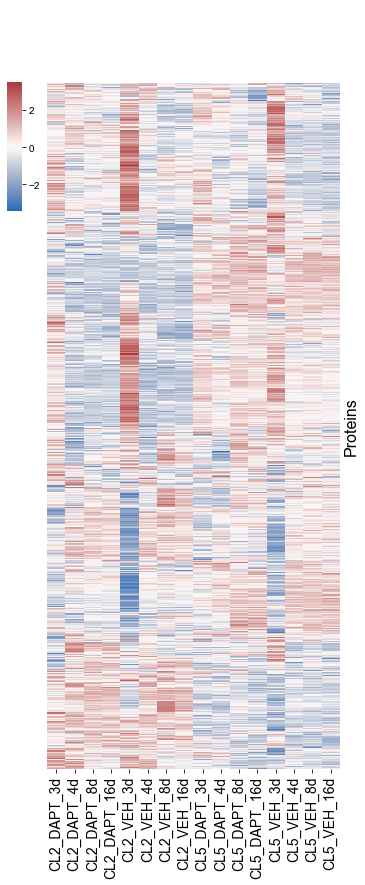

In [25]:
# clustered heatmap
g = sns.clustermap(
        dfz_2,
        method="average",        # linkage
        metric="correlation",    # best for expression-style data
        cmap="vlag",
        figsize=(5, 12),
        yticklabels=False,
        row_cluster=True,   # remove Y-axis dendrogram
        col_cluster=False,   # remove X-axis dendrogram
        dendrogram_ratio=(0.1, 0.1),
        cbar_pos=(0.01, 0.75, 0.04, 0.15)
    )


# hide Y-axis dendrogram (rows)
g.ax_row_dendrogram.set_visible(False)
# g.ax_heatmap.set_xlabel("Samples", fontsize=18)
g.ax_heatmap.set_ylabel("Proteins", fontsize=16)
g.ax_heatmap.tick_params(axis='x', labelsize=14, labelcolor='black', rotation=90)
# g.ax_heatmap.tick_params(axis='y', labelsize=14, labelcolor='black', rotation=0)

plt.savefig(r"F:\neuron project with Jesus\figures\heatmap_16treatments.png", 
            dpi=800, bbox_inches="tight")
plt.show()